In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

In [7]:
log_path = Path(f"logs_h100/")
from dataclasses import dataclass

def get_mem(dfs):
    mems = []
    for df in dfs:
        if not isinstance(df, pd.DataFrame):
            mems.append(0)
            continue

        df["mem"] = df.apply(lambda x: x[" used_gpu_memory [MiB]"].strip(" MiB"), axis=1).astype(int)
        mem = df.groupby([" pid"]).max()["mem"].sum()
        mems.append(mem)
    return mems

@dataclass
class Experiment:
    name: str
    batch_size: int
    train_workers: int
    validation_workers: int
    prefetch_factor: int
    model_name: str
    dataset: str

    pids: list
    trace_pids: list
    pids_full_nonshared: list
    pids_full_shared: list
    workloads: list

    @property
    def train_path(self):
        return log_path / "queues" / self.dataset / self.model_name

    @property
    def model_path_prefix(self):
        return f"{self.model_name}_{self.train_workers}tw_{self.validation_workers}vw_{self.prefetch_factor}pf_pid"

    @property
    def naive(self):
        return [
            [
                pd.read_csv(self.train_path / f"{self.model_path_prefix}_{j}.csv")
                if j != 0
                else 0
                for j in self.pids_full_nonshared[i]
            ]
            for i in range(0, len(self.pids_full_nonshared))
        ]

    @property
    def throughput_naive(self):
        return [
            sum(
                [
                    df.iloc[2:]["throughput"].mean()
                    if isinstance(df, pd.DataFrame)
                    else 0
                    for df in x
                ]
            )
            for x in self.naive
        ]

    @property
    def throughput_naive_normalized(self):
        return [x / self.throughput_naive[0] for x in self.throughput_naive]

    @property
    def time_naive(self):
        return [
            df.iloc[2:]["total_time"].mean() if isinstance(df, pd.DataFrame) else 0
            for df in self.naive
        ]

    @property
    def shared(self):
        return [
            [
                pd.read_csv(self.train_path / f"{self.model_path_prefix}_{j}.csv")
                if j != 0
                else 0
                for j in self.pids_full_shared[i]
            ]
            for i in range(0, len(self.pids_full_shared))
        ]

    @property
    def throughput_shared(self):
        return [
            sum(
                [
                    df.iloc[2:]["throughput"].mean()
                    if isinstance(df, pd.DataFrame)
                    else 0
                    for df in x
                ]
            )
            for x in self.shared
        ]

    @property
    def throughput_shared_normalized(self):
        return [x / self.throughput_naive[0] for x in self.throughput_shared]

    @property
    def time_shared(self):
        return [
            df.iloc[2:]["total_time"].mean() if isinstance(df, pd.DataFrame) else 0
            for df in self.shared
        ]

    @property
    def memory_naive(self):
        return get_mem([pd.read_csv(self.train_path / f"{self.model_path_prefix}_{self.pids[i]}_gpu_util.csv") if self.pids[i]!=0 else 0 for i in range(0, len(self.workloads))])

    @property
    def memory_shared(self):
        return get_mem([pd.read_csv(self.train_path / f"{self.model_path_prefix}_{self.pids[i]}_gpu_util.csv") if self.pids[i]!=0 else 0 for i in range(len(self.workloads), 2*len(self.workloads))])

        


# Imagenet
imagenet_efficientformer = Experiment(
    name="EF",
    batch_size=128,
    train_workers=12,
    validation_workers=8,
    prefetch_factor=2,
    model_name=f"efficientformer_l1_bs128",
    dataset="imagenet",
    pids=[
        97004,
        99054,
        102859,
        108365,  # Baseline
        117743,
        119804,
        122819,
        125547,  # Shared
    ],
    trace_pids=[
        96947,
        98943,
        102647,
        108002,  # Baseline
        117685,
        119748,
        122649,
        125492,  # Shared
    ],
    pids_full_nonshared=[
        [97004],
        [99054, 99056],
        [102859, 102909, 103013],
        [108365, 108416, 108568, 108764],
    ],
    pids_full_shared=[
        [117743],
        [119804, 119807],
        [122819, 122869, 122877],
        [125547, 125550, 125605, 125612],
    ],
    workloads=("1x EF", "2x EF", "3x EF", "4x EF"),
)

imagenet_resnet = Experiment(
    name="ResNet",
    batch_size=128,
    train_workers=12,
    validation_workers=8,
    prefetch_factor=2,
    model_name=f"resnet50_bs128",
    dataset="imagenet",
    pids=[
        129324,
        131527,
        141493,
        154583,  # Baseline
        2467,
        4093,
        5821,
        7933,  # Shared
    ],
    trace_pids=[
        129268,
        131417,
        141236,
        154175,  # Baseline
        2410,
        4034,
        5764,
        7876,  # Shared
    ],
    pids_full_nonshared=(
        (129324,),
        (131527, 131576),
        (141493, 141496, 141652),
        (154583, 154587, 154794, 154846),
    ),  # Baseline
    pids_full_shared=(
        (2467,),
        (4093, 4095),
        (5821, 5822, 5877),
        (7933, 7935, 7991, 8048),
    ),  # Shared
    workloads=("1x RN50", "2x RN50", "3x RN50", "4x RN50"),
)

# COCO
coco_faster = Experiment(
    name="Faster",
    batch_size=4,
    train_workers=1,
    validation_workers=1,
    prefetch_factor=1,
    model_name=f"fasterrcnn_resnet50_fpn_bs4",
    dataset="coco",
    pids=[
        64155,
        67877,
        71520,
        72821,
        # 64155,67877,
        # 71520,72821,
    ],
    trace_pids=[
        64108,
        67247,
        71475,
        72754,
    ],
    pids_full_nonshared=((64155,), (67849, 67853, 67869, 67877)),  # Baseline
    pids_full_shared=((71520,), (72800, 72805, 72814, 72821)),  # Shared
    workloads=("1x FRCNN", "4x FRCNN"),
)

coco_retina = Experiment(
    name="Retina",
    batch_size=4,
    train_workers=1,
    validation_workers=1,
    prefetch_factor=1,
    model_name=f"retinanet_resnet50_fpn_bs4",
    dataset="coco",
    pids=[
        17809,
        3907,
        0,
        12219,
    ],
    trace_pids=[
        17762,
        3531,
        0,
        12146,
    ],
    pids_full_nonshared=((17809,), (3885, 3887, 3896, 3907)),  # Baseline
    pids_full_shared=((0,), (12195, 12196, 12215, 12219)),  # Shared
    workloads=("1x RetNet", "4x RetNet"),
)

[0, 0]

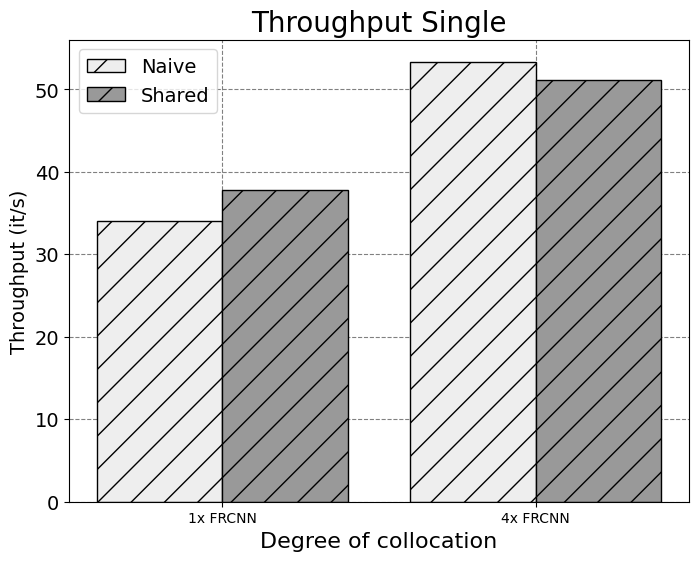

In [12]:
### SINGLE EXPERIMENT

import matplotlib.pyplot as plt
import numpy as np

# exp = imagenet_resnet
# exp = imagenet_efficientformer
exp = coco_faster
# exp = coco_retina

measurements ={
    "Naive": exp.throughput_naive,
    "Shared": exp.throughput_shared,
}


x = np.arange(len(exp.workloads))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0.5

fig, ax = plt.subplots(figsize=(8,6))
hatches = ["/", "/", "/", "///", "///", "///"]
hatch_cols = ["#eeeeee", "#999999", "#666666",
              "#eeeeee", "#999999", "#666666"]

for idx, (attribute, measurement) in enumerate(measurements.items()):
    offset = width * multiplier
    #rects = ax.bar(x + offset, measurement, width, label=attribute, color=shades[idx], edgecolor="black", yerr=measurements_err[attribute][idx], ecolor="red", capsize=5)
    rects = ax.bar(x + offset, measurement, width, label=attribute, hatch=hatches[idx], color=hatch_cols[idx], edgecolor="black")
    #ax.bar_label(rects, padding=3, fmt='%.0f', label_type="edge", color="black", size=16)
    multiplier += 1


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Throughput (it/s)', fontsize=14)
ax.set_title(f'Throughput Single', fontsize=20)
ax.set_xticks(x + width)
ax.set_xticklabels(exp.workloads)
ax.legend(loc='upper left', fontsize=14)

ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
if exp.dataset == "imagenet":
    plt.yticks([i for i in range(0, 2501, 500)], fontsize=14)
elif exp.dataset == "coco":
    plt.yticks([i for i in range(0, 51, 10)], fontsize=14)
plt.xlabel("Degree of collocation", fontsize=16)

plt.rcParams['svg.fonttype'] = 'none'
plt.savefig("efficienttransformer_throughput.pdf")
plt.show()

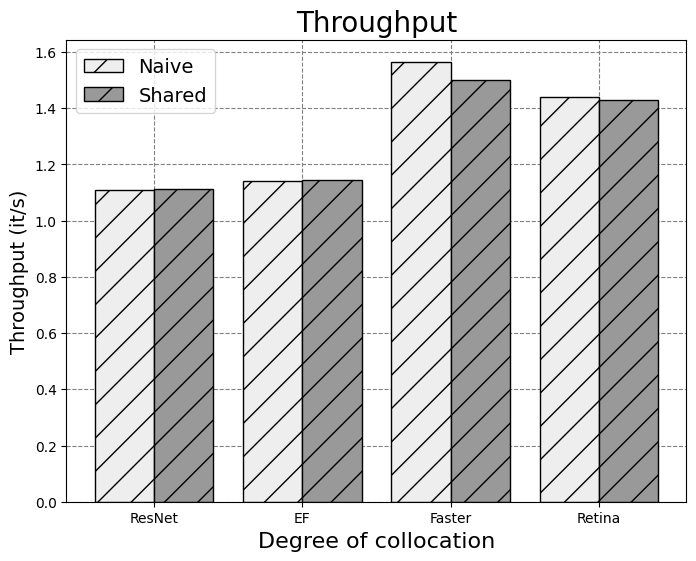

In [14]:
### MULTIPLE EXPERIMENTS

import matplotlib.pyplot as plt
import numpy as np

experiments = (imagenet_resnet, imagenet_efficientformer, coco_faster, coco_retina)


measurements ={
    "Naive": [x.throughput_naive_normalized[-1] for x in experiments],
    "Shared": [x.throughput_shared_normalized[-1] for x in experiments]
}

x = np.arange(len(experiments))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0.5

fig, ax = plt.subplots(figsize=(8,6))
hatches = ["/", "/", "/", "///", "///", "///"]
hatch_cols = ["#eeeeee", "#999999", "#666666",
              "#eeeeee", "#999999", "#666666"]

for idx, (attribute, measurement) in enumerate(measurements.items()):
    offset = width * multiplier
    #rects = ax.bar(x + offset, measurement, width, label=attribute, color=shades[idx], edgecolor="black", yerr=measurements_err[attribute][idx], ecolor="red", capsize=5)
    rects = ax.bar(x + offset, measurement, width, label=attribute, hatch=hatches[idx], color=hatch_cols[idx], edgecolor="black")
    #ax.bar_label(rects, padding=3, fmt='%.0f', label_type="edge", color="black", size=16)
    multiplier += 1


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Throughput (it/s)', fontsize=14)
ax.set_title(f'Throughput', fontsize=20)
ax.set_xticks(x + width)
ax.set_xticklabels([x.name for x in experiments])
ax.legend(loc='upper left', fontsize=14)

ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
# if exp.dataset == "imagenet":
#     plt.yticks([i for i in range(0, 2501, 500)], fontsize=14)
# elif exp.dataset == "coco":
#     plt.yticks([i for i in range(0, 51, 10)], fontsize=14)
plt.xlabel("Degree of collocation", fontsize=16)

plt.rcParams['svg.fonttype'] = 'none'
plt.savefig("efficienttransformer_throughput.pdf")
plt.show()

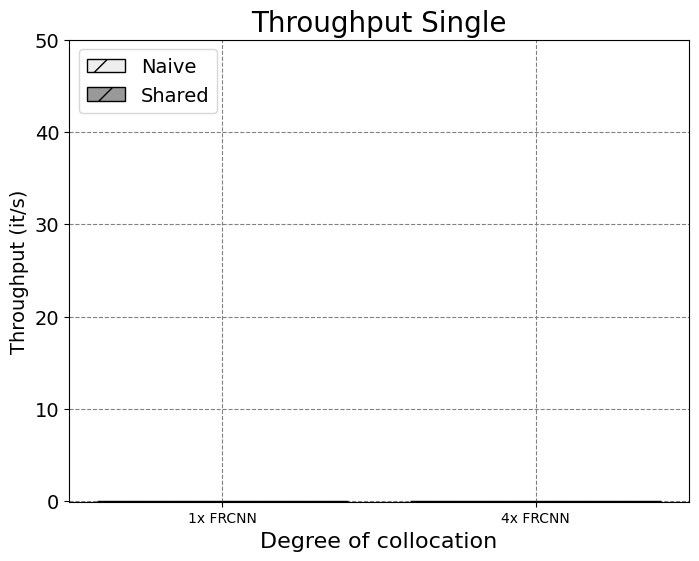

In [16]:
# ### SINGLE EXPERIMENT TIME

# import matplotlib.pyplot as plt
# import numpy as np

# # exp = imagenet_resnet
# # exp = imagenet_efficientformer
# exp = coco_faster
# # exp = coco_retina

# measurements ={
#     "Naive": exp.time_naive,
#     "Shared": exp.time_shared,
# }


# x = np.arange(len(exp.workloads))  # the label locations
# width = 0.4  # the width of the bars
# multiplier = 0.5

# fig, ax = plt.subplots(figsize=(8,6))
# hatches = ["/", "/", "/", "///", "///", "///"]
# hatch_cols = ["#eeeeee", "#999999", "#666666",
#               "#eeeeee", "#999999", "#666666"]

# for idx, (attribute, measurement) in enumerate(measurements.items()):
#     offset = width * multiplier
#     #rects = ax.bar(x + offset, measurement, width, label=attribute, color=shades[idx], edgecolor="black", yerr=measurements_err[attribute][idx], ecolor="red", capsize=5)
#     rects = ax.bar(x + offset, measurement, width, label=attribute, hatch=hatches[idx], color=hatch_cols[idx], edgecolor="black")
#     #ax.bar_label(rects, padding=3, fmt='%.0f', label_type="edge", color="black", size=16)
#     multiplier += 1


# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Time (s)', fontsize=14)
# ax.set_title(f'Time Single', fontsize=20)
# ax.set_xticks(x + width)
# ax.set_xticklabels(exp.workloads)
# ax.legend(loc='upper left', fontsize=14)

# ax.set_axisbelow(True)
# ax.grid(color='gray', linestyle='dashed')
# if exp.dataset == "imagenet":
#     plt.yticks([i for i in range(0, 2501, 500)], fontsize=14)
# elif exp.dataset == "coco":
#     plt.yticks([i for i in range(0, 51, 10)], fontsize=14)
# plt.xlabel("Degree of collocation", fontsize=16)

# plt.rcParams['svg.fonttype'] = 'none'
# plt.savefig("efficienttransformer_throughput.pdf")
# plt.show()

In [ ]:
# def get_mem(dfs):
#     mems = []
#     for df in dfs:
#         df["mem"] = df.apply(lambda x: x[" used_gpu_memory [MiB]"].strip(" MiB"), axis=1).astype(int)
#         mem = df.groupby([" pid"]).max()["mem"].sum()
#         mems.append(mem)
#     return mems

In [ ]:
# if DATASET == "imagenet":
#     if model_name.startswith("efficientformer"):
#         workloads = ("1x EF", "2x EF", "3x EF", "4x EF")
#     elif model_name.startswith("resnet50"):
#         workloads = ("1x RN50", "2x RN50", "3x RN50", "4x RN50")

#     naive_mem = [pd.read_csv(train_path / f"{model_path_prefix}_{pids[i]}_gpu_util.csv") for i in range(0, 4)]

#     shared_mem = [pd.read_csv(train_path / f"{model_path_prefix}_{pids[i]}_gpu_util.csv") for i in range(4, 8)]

# elif DATASET == "coco":
#     if model_name_1.startswith("fasterrcnn"):
#         workloads = ("1x FRCNN", "4x FRCNN")
#     elif model_name_1.startswith("retinanet"):
#         workloads = ("1x RetNet", "4x RetNet")

#     naive_mem = [pd.read_csv(train_path / f"{model_path_prefix}_{pids[i]}_gpu_util.csv") for i in range(0, 2)]
#     shared_mem = [pd.read_csv(train_path / f"{model_path_prefix}_{pids[i]}_gpu_util.csv") for i in range(2, 4)]

# naive_mem = get_mem(naive_mem)
# shared_mem = get_mem(shared_mem)

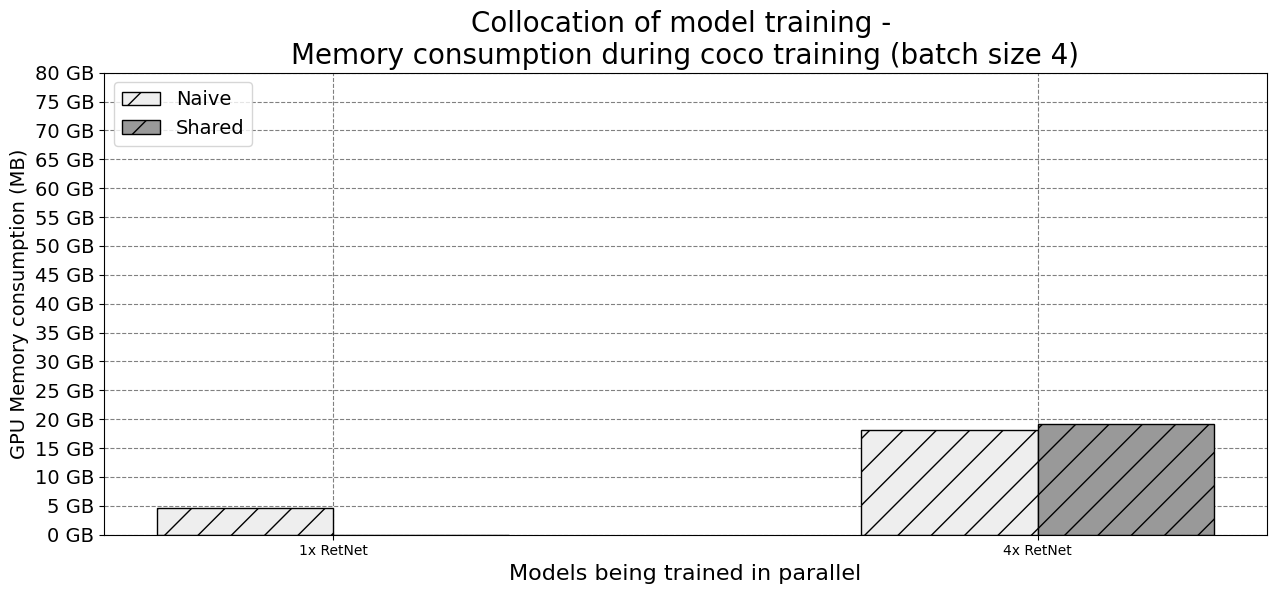

In [13]:
### MEMORY SINGLE

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# exp = imagenet_resnet
# exp = imagenet_efficientformer
# exp = coco_faster
exp = coco_retina

measurements ={
    "Naive": exp.memory_naive,
    "Shared": exp.memory_shared,
}

x = np.arange(len(exp.workloads))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0.5

fig, ax = plt.subplots(figsize=(15,6))
hatches = ["/", "/", "/", "///", "///", "///"]
hatch_cols = ["#eeeeee", "#999999", "#666666", 
              "#eeeeee", "#999999", "#666666"]

for idx, (attribute, measurement) in enumerate(measurements.items()):
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, hatch=hatches[idx], color=hatch_cols[idx], edgecolor="black")
    #ax.bar_label(rects, padding=3, fmt='%.0f', label_type="edge", color="black", size=16)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('GPU Memory consumption (MB)', fontsize=14)
ax.set_title(f'Collocation of model training - \nMemory consumption during {exp.dataset} training (batch size {exp.batch_size})', fontsize=20)
ax.set_xticks(x + width)
ax.set_xticklabels(exp.workloads)
ax.legend(loc='upper left', fontsize=14)

ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')

fmt = lambda x, pos: '{:.0f} GB'.format(x/1000, pos)
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt))

plt.yticks([i for i in range(0, 81559, 5000)], fontsize=14)
plt.xlabel("Models being trained in parallel", fontsize=16)
plt.show()

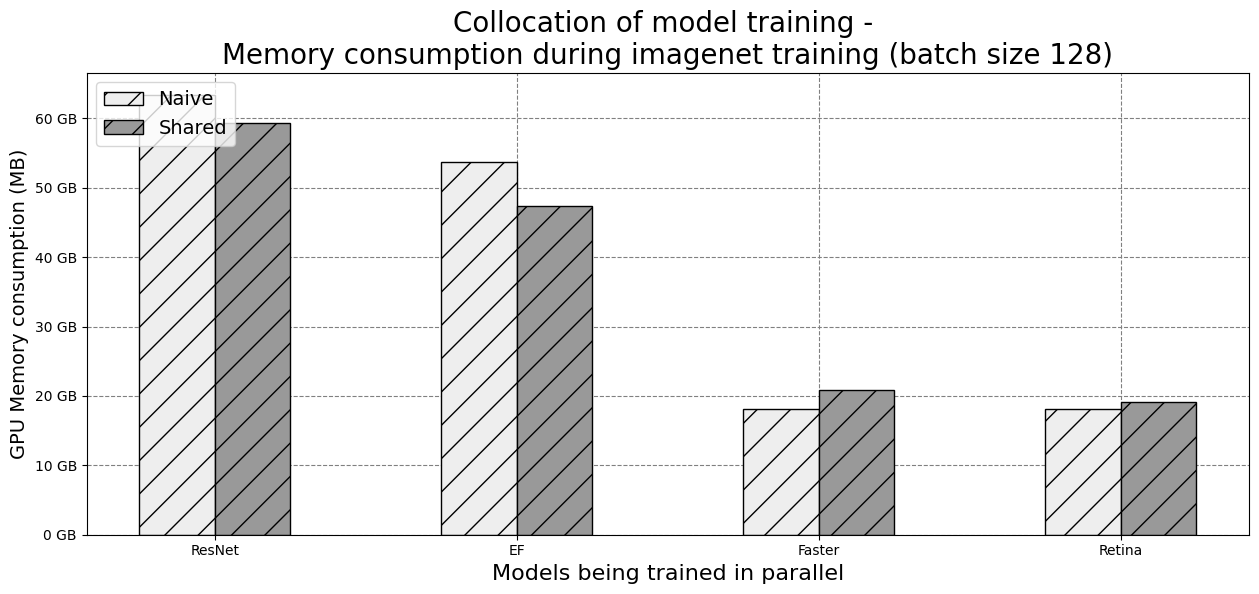

In [9]:
### MEMORY MULTI


import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

experiments = (imagenet_resnet, imagenet_efficientformer, coco_faster, coco_retina)


measurements ={
    "Naive": [x.memory_naive[-1] for x in experiments],
    "Shared": [x.memory_shared[-1] for x in experiments]
}




x = np.arange(len(experiments))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0.5

fig, ax = plt.subplots(figsize=(15,6))
hatches = ["/", "/", "/", "///", "///", "///"]
hatch_cols = ["#eeeeee", "#999999", "#666666", 
              "#eeeeee", "#999999", "#666666"]

for idx, (attribute, measurement) in enumerate(measurements.items()):
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, hatch=hatches[idx], color=hatch_cols[idx], edgecolor="black")
    #ax.bar_label(rects, padding=3, fmt='%.0f', label_type="edge", color="black", size=16)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('GPU Memory consumption (MB)', fontsize=14)
ax.set_title(f'Collocation of model training - \nMemory consumption during {exp.dataset} training (batch size {exp.batch_size})', fontsize=20)
ax.set_xticks(x + width)
ax.set_xticklabels([x.name for x in experiments])
ax.legend(loc='upper left', fontsize=14)

ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')

fmt = lambda x, pos: '{:.0f} GB'.format(x/1000, pos)
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt))

# plt.yticks([i for i in range(0, 81559, 5000)], fontsize=14)
plt.xlabel("Models being trained in parallel", fontsize=16)
plt.show()

In [ ]:
import matplotlib as mpl

measurements ={
    "Naive": naive,
    "Shared": shared,
}

measurements_mem = {
    "Naive": naive_mem,
    "Shared": shared_mem,
}

x = np.arange(len(workloads))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0.5

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharey=False)
hatches = ["/", "/", "/", "///", "///", "///"]
hatch_cols = ["#eeeeee", "#999999", "#666666",
              "#eeeeee", "#999999", "#666666"]

# Plot measurements1 in the first subplot
for idx, (attribute, measurement) in enumerate(measurements.items()):
    offset = width * multiplier
    rects = ax1.bar(x + offset, measurement, width, label=attribute, hatch=hatches[idx],
                    color=hatch_cols[idx], edgecolor="black")
    multiplier += 1

# Plot measurements2 in the second subplot
for idx, (attribute, measurement) in enumerate(measurements_mem.items()):
    offset = width * multiplier
    rects = ax2.bar(x + offset, measurement, width, label=attribute, hatch=hatches[idx],
                    color=hatch_cols[idx], edgecolor="black")
    multiplier += 1

# Add labels, titles, etc. to the subplots
ax1.set_ylabel('Epoch Time (seconds)', fontsize=10)
ax2.set_ylabel('GPU Memory consumption (MB)', fontsize=10)
ax1.set_xlabel("A", fontsize=14)
ax2.set_xlabel("B", fontsize=14)

ax1.set_xticks(x + width)
ax1.set_xticklabels(workloads)
ax2.set_xticks(x + width+0.4)
ax2.set_xticklabels(workloads)

handles, labels = plt.gca().get_legend_handles_labels()
#order = [0,3,1,4,2,5]
#ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper left', fontsize=8, ncol=3)
ax1.legend()

if DATASET == "imagenet":
    ax1.set(yticks=[i for i in range(0, 5001, 500)])
    ax2.set(yticks=[i for i in range(0, 81559, 5000)])
elif DATASET == "coco":
    ax1.set(yticks=[i for i in range(0, 51, 10)])
    ax2.set(yticks=[i for i in range(0, 81559, 5000)])

fmt = lambda x, pos: '{:.0f} GB'.format(x/1000, pos)
ax2.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt))

for ax in [ax1, ax2]:
    ax.set_axisbelow(True)
    ax.grid(color='gray', linestyle='dashed')

plt.tight_layout()
plt.show()


In [ ]:
cols = ["running_seconds", "txtpt", "rxtpt", "gputl", "mcutl", "musam", "gusam", "smact", "smocc", "tenso", "drama", "pcitx", "pcirx"]

def get_feat_mean(path, feat="smact"):
    with open(path) as f:
        next(f)
        next(f)
        lines = f.readlines()
        lines = [l for l in lines if l != "\n"]
        lines = [l.strip() for l in lines if not (("#Entity" in l) or ("ID" in l))]
        lines = [l.split()[2:] for l in lines]
        lines = [[i+1] + l for i,l in enumerate(lines)]

    df = pd.DataFrame(lines, columns=cols)
    df[feat] = df[feat].replace("N/A", 0.0)
    df[feat] = df[feat].astype(float)
    df = df[df[feat] != 0.0]
    return df[feat].mean()

In [ ]:
feat = "smact"

if DATASET == "imagenet":
    if model_name.startswith("efficientformer"):
        workloads = ("1x EF", "2x EF", "3x EF", "4x EF")
    elif model_name.startswith("resnet50"):
        workloads = ("1x RN50", "2x RN50", "3x RN50", "4x RN50")

    naive = [get_feat_mean(train_path / f"pid_{trace_pids[i]}_dcgm.out", feat) for i in range(0, 4)]

    shared = [get_feat_mean(train_path / f"pid_{trace_pids[i]}_dcgm.out", feat) for i in range(4, 8)]

measurements_smact ={
    "Naive": naive,
    "Shared": shared,
}



In [ ]:
feat = "smocc"

if DATASET == "imagenet":
    if model_name.startswith("efficientformer"):
        workloads = ("1x EF", "2x EF", "3x EF", "4x EF")
    elif model_name.startswith("resnet50"):
        workloads = ("1x RN50", "2x RN50", "3x RN50", "4x RN50")

    naive = [get_feat_mean(train_path / f"pid_{trace_pids[i]}_dcgm.out", feat) for i in range(0, 4)]

    shared = [get_feat_mean(train_path / f"pid_{trace_pids[i]}_dcgm.out", feat) for i in range(4, 8)]

measurements_smocc ={
    "Naive": naive,
    "Shared": shared,
}



In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

x = np.arange(len(workloads))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0.5

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharey=False)
hatches = ["/", "/", "/", "///", "///", "///"]
hatch_cols = ["#eeeeee", "#999999", "#666666",
              "#eeeeee", "#999999", "#666666"]

# Plot measurements1 in the first subplot
for idx, (attribute, measurement) in enumerate(measurements_smact.items()):
    offset = width * multiplier
    rects = ax1.bar(x + offset, measurement, width, label=attribute, hatch=hatches[idx],
                    color=hatch_cols[idx], edgecolor="black")
    multiplier += 1

# Plot measurements2 in the second subplot
for idx, (attribute, measurement) in enumerate(measurements_smocc.items()):
    offset = width * multiplier
    rects = ax2.bar(x + offset, measurement, width, label=attribute, hatch=hatches[idx],
                    color=hatch_cols[idx], edgecolor="black")
    multiplier += 1

# Add labels, titles, etc. to the subplots
ax1.set_ylabel('SMACT %-Utilization', fontsize=10)
ax2.set_ylabel('SMOCC %-Utilization', fontsize=10)
#ax1.set_ylabel('Epoch Time (seconds)', fontsize=10)
#ax2.set_ylabel('GPU Memory consumption (MB)', fontsize=10)
ax1.set_xlabel("A", fontsize=14)
ax2.set_xlabel("B", fontsize=14)

ax1.set_xticks(x + width)
ax1.set_xticklabels(workloads)
ax2.set_xticks(x + width+0.4)
ax2.set_xticklabels(workloads)

handles, labels = plt.gca().get_legend_handles_labels()
#order = [0,2,1,3,4,5]
#order = [0,3,1,4,2,5]
#ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper left', fontsize=8, ncol=3, bbox_to_anchor=(0, 1.2))
ax1.legend()

fmt = lambda x, pos: '{:.0f}%'.format(x*100)
ax1.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt))
ax2.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt))

ax1.set(yticks=[i/10 for i in range(0, 11)])
ax2.set(yticks=[i/10 for i in range(0, 11)])

for ax in [ax1, ax2]:
    ax.set_axisbelow(True)
    ax.grid(color='gray', linestyle='dashed')

plt.tight_layout()
plt.show()


In [ ]:
cols = ["time", "cpu", "%usr", "%nice", "%sys", "%iowait", "%irq", "%soft", "%steal", "%guest", "%gnice", "%idle"]

def create_plottable_df(path, log_path):
    with open(path) as f:
        lines = f.readlines()
        lines = [l for l in lines if l != "\n"]
        lines = [l.strip() for l in lines if not "CPU" in l]
        lines = [l.split() for l in lines]
    df_log = pd.read_csv(log_path)
    last_time = (pd.to_datetime(df_log['timestamp'], unit="s", utc=True).dt.tz_convert('Europe/Berlin')).iloc[-1].to_datetime64()
    date = (pd.to_datetime(df_log['timestamp'], unit="s", utc=True).dt.tz_convert('Europe/Berlin')).iloc[-1].date().strftime("%Y-%m-%d ")
    new_lines = []

    for line in lines:
        new_line = []
        for idx, l in enumerate(line):
            if idx == 0:
                new_line.append(l)
            else:
                new_line.append(float(l))
        new_lines.append(new_line)
    df = pd.DataFrame(new_lines, columns=cols)
    df['time'] = date + df['time']
    try:
        df['running_seconds'] = pd.to_datetime(df['time']) - pd.DateOffset(hours=2)
        df = df[pd.to_datetime(df['running_seconds']) < last_time]

        first_timestamp = df['running_seconds'].iloc[0]
        df['running_seconds'] = (df['running_seconds'] - first_timestamp).dt.total_seconds()
        df['running_seconds_normalized'] = (df['running_seconds'] - df['running_seconds'].min()) / (df['running_seconds'].max() - df['running_seconds'].min()) * 99 + 1
    except:
        print(f"Failed extracting logs for {path}")
    return df

In [ ]:
def set_measurements(dfs, measurements, title, metric):
    xs = []
    ys = []
    for idx, df in enumerate(dfs):
        #average_all_cpus = df.groupby(group)[metric].mean()
        avg = df[metric].mean()
        xs.append(idx)
        ys.append(avg)
        if measurements.get(title):
            measurements[title].append(avg)
        else:
            measurements[title] = [avg]
    #return xs, ys
    return measurements

In [ ]:
measurements = {}
if model_name.startswith("efficientformer"):
    suptitles = [f"{i}x EF" for i in range(1,5)]
elif model_name.startswith("resnet50"):
    suptitles = [f"{i}x RN50" for i in range(1,5)]

naive = [train_path / f"pid_{trace_pids[i]}_cpu.out" for i in range(0, 4)]
naive_logs = [train_path / f"{model_path_prefix}_{pids[i]}.csv" for i in range(0, 4)]
naive_dfs = [create_plottable_df(path, naive_logs[idx]) for idx, path in enumerate(naive)]

shared = [train_path / f"pid_{trace_pids[i]}_cpu.out" for i in range(4, 8)]
shared_logs = [train_path / f"{model_path_prefix}_{pids[i]}.csv" for i in range(4, 8)]
shared_dfs = [create_plottable_df(path, shared_logs[idx]) for idx, path in enumerate(shared)]

measurements = set_measurements(naive_dfs, measurements, "Naive", "%usr")
measurements = set_measurements(shared_dfs, measurements, "Shared", "%usr")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(suptitles))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0.5

fig, ax = plt.subplots(figsize=(15,6))
hatches = ["/", "/", "/", "///", "///", "///"]
hatch_cols = ["#eeeeee", "#999999", "#666666",
              "#eeeeee", "#999999", "#666666"]

for idx, (attribute, measurement) in enumerate(measurements.items()):
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, hatch=hatches[idx], color=hatch_cols[idx], edgecolor="black")
    #ax.bar_label(rects, padding=3, fmt='%.0f', label_type="edge", color="black", size=16)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% CPU Utilization', fontsize=14)
#ax.set_title(f'Collocation of model training - {MACHINE}\nMemory consumption during {DATASET} training (batch size {BATCH_SIZE})', fontsize=20)
ax.set_xticks(x + width)
ax.set_xticklabels(suptitles)
#ax.legend(loc='upper left', fontsize=14, ncol=3)
handles, labels = plt.gca().get_legend_handles_labels()
#order = [0,2,1,3,4,5]
#order = [0,3,1,4,2,5]
#ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper left', fontsize=14, ncol=3)
ax.legend()

ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
plt.yticks([i for i in range(0, 101, 10)], fontsize=14)
#plt.xlabel("Models being trained in parallel", fontsize=16)
plt.show()

## Everything below this is the wild west

In [ ]:
def plot_dfs(dfs, title, titles, metric, normalized=True):
    xs = []
    ys = []
    fig, ax = plt.subplots(figsize=(8,4))
    width = 0.25  # the width of the bars
    multiplier = -1.5
    
        
    for idx, df in enumerate(dfs):
        #average_all_cpus = df.groupby(group)[metric].mean()
        avg = df[metric].mean()
        xs.append(idx)
        ys.append(avg)

        #plt.plot(average_all_cpus.index, average_all_cpus.values, \
        #            linewidth=1, label=titles[idx])
        #plt.hist(xs, ys, label=titles[idx])
    #return xs, ys
    ax.bar(xs, ys, width, color="#666666")
    ax.set_xticks(xs, titles, fontsize=10, rotation=45, ha="right")

    #plt.legend()
    ax.set_axisbelow(True)
    ax.grid(color='gray', linestyle='dashed')
    plt.ylim(0,100)
    plt.show()

In [ ]:
def plot_dfs(measurements, title, titles):
    xs = []
    ys = []
    fig, ax = plt.subplots(figsize=(8,4))
    width = 0.25  # the width of the bars
    multiplier = -1.5
    xs = np.arange(len(measurements))
    ys = measurements

    ax.bar(xs, ys, width, color="#666666")
    ax.set_xticks(xs, titles, fontsize=10, rotation=45, ha="right")

    plt.ylabel('% GPU memory usage')
    plt.title(f'{title}\nGPU memory usage')

    ax.set_axisbelow(True)
    ax.grid(color='gray', linestyle='dashed')
    plt.ylim(0,100)
    plt.show()

In [ ]:
plot_dfs(naive_mem_pct, f"Naive RN18 training workload, Dataset: {DATASET}", [f"{i}x RN18" for i in range(1,5)])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

measurements ={
    "Naive": naive_mem_pct,
}
titles = naive_suptitles = [f"{i}x RN18" for i in range(1,5)]
x = np.arange(len(workloads))  # the label locations
width = 0.25  # the width of the bars
multiplier = -1.5

fig, ax = plt.subplots(layout='constrained', figsize=(8,4))
hatches = ["/", "/", "/", "///", "///", "///"]
hatch_cols = ["#eeeeee", "#999999", "#666666", 
              "#eeeeee", "#999999", "#666666"]

for idx, (attribute, measurement) in enumerate(measurements.items()):
    offset = width * multiplier
    rects = ax.bar(x, measurement, width, label=attribute, hatch=hatches[idx], color=hatch_cols[idx], edgecolor="black")
    #ax.bar_label(rects, padding=3, fmt='%.0f', label_type="edge", color="black", size=16)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('GPU Memory consumption (MB)', fontsize=14)
ax.set_title(f"Naive RN18 training workload, Dataset: {DATASET}\nGPU memory usage")
#ax.set_xticks(x + width, workloads, fontsize=14)
ax.set_xticks(x, titles, fontsize=10, rotation=45, ha="right")
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
plt.yticks([i for i in range(0, 100, 10)], fontsize=14)
plt.xlabel("Models being trained in parallel", fontsize=16)
plt.show()

In [ ]:
def create_cpu_norm_df(path):
    cols = ["total", "used", "free", "shared", "buff/cache", "available"]

    with open(path, "r") as f:
        lines = f.readlines()

    new_lines = []

    for l in lines:
        if l.startswith("Mem"):
            l = l.split()
            new_lines.append([int(i) for i in l[1:]])
    df = pd.DataFrame(new_lines, columns=cols)
    df_norm = df.iloc[:, 1:-1].div(df.iloc[:, 1:-1].sum(axis=1), axis=0)
    df_norm = df_norm[["used", "buff/cache", "shared", "free"]]
    return df_norm

In [ ]:
def plot_cpu_mem(df, idx):
    colors = {
        "free": "#CCCCCC",
        "used": "#004080",
        "shared": "#FFCC66",
        "buff/cache": "#66CC99"
    }

    ax = df.plot.area(color=colors, legend=False)

    num_rows = len(df.index)

    ax.set_xticks([])
    ax.set_xticklabels([])
    
    if idx == 0:
        handles, labels = ax.get_legend_handles_labels()
        #ax.legend(handles, labels, ncol=4, bbox_to_anchor=(0.14, 1), fontsize=20)
        ax.set_ylabel('CPU Memory usage', fontsize=20)
        ax.set_xlabel("1x RN18", fontsize=20)
    ax.tick_params(axis='y', labelsize=20)

    ax.grid(color="black", linewidth=2)
    if idx == 1:
        ax.set_xlabel("2x RN18", fontsize=20)
    if idx == 2:
        ax.set_xlabel("3x RN18", fontsize=20)
    if idx == 3:
        ax.set_xlabel("4x RN18", fontsize=20)

    fmt = lambda x, pos: '{:.0f}%'.format(x*100, pos)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt))
    
    plt.ylim(0,1)
    plt.xlim(0,num_rows)
    plt.show()


In [ ]:
import matplotlib as mpl

naive = [train_path / model_name / f"pid_{trace_pids[i]}_free.out" for i in range(0, 4)]

for idx, path in enumerate(naive):
    df = create_cpu_norm_df(path)
    plot_cpu_mem(df, idx)

In [ ]:
shared = [train_mul_path / f"pid_{trace_pids[i]}_free.out" for i in range(4, 8)]

for idx, path in enumerate(shared):
    df = create_cpu_norm_df(path)
    plot_cpu_mem(df, idx)

In [ ]:
cols = ["time", "cpu", "%usr", "%nice", "%sys", "%iowait", "%irq", "%soft", "%steal", "%guest", "%gnice", "%idle"]

def create_plottable_df(path, log_path):
    df_log = pd.read_csv(log_path)
    last_time = (pd.to_datetime(df_log['timestamp'], unit="s", utc=True).dt.tz_convert('Europe/Berlin')).iloc[-1].to_datetime64()

    with open(path) as f:
        lines = f.readlines()
        lines = [l for l in lines if l != "\n"]
        lines = [l.strip() for l in lines if not "CPU" in l]
        lines = [l.split() for l in lines]

    new_lines = []

    for line in lines:
        new_line = []
        for idx, l in enumerate(line):
            if idx == 0:
                new_line.append(l)
            else:
                new_line.append(float(l))
        new_lines.append(new_line)
    df = pd.DataFrame(new_lines, columns=cols)
    df = df[pd.to_datetime(df['time'], unit='ns') < last_time]
    df['running_seconds'] = pd.to_datetime(df['time'], unit='ns')

    first_timestamp = df['running_seconds'].iloc[0]
    df['running_seconds'] = (df['running_seconds'] - first_timestamp).dt.total_seconds()
    df['running_seconds_normalized'] = (df['running_seconds'] - df['running_seconds'].min()) / (df['running_seconds'].max() - df['running_seconds'].min()) * 99 + 1
    
    return df

In [ ]:
def plot_dfs(dfs, title, titles, metric, normalized=True):
    fig, ax = plt.subplots(figsize=(12,8))
    if normalized:
        group = 'running_seconds_normalized'
    else:
        group = 'running_seconds'
    for idx, df in enumerate(dfs):
        average_all_cpus = df.groupby(group)[metric].mean()

        plt.plot(average_all_cpus.index, average_all_cpus.values, \
                    linewidth=1, label=titles[idx])
    if normalized:
        plt.xlabel('Running time, normalized %')
    else:
        plt.xlabel('Running time (seconds)')
    if metric in ["%usr", "%nice"]:
        plt.ylabel('% CPU Utilization')
        plt.title(f'{title}\nCPU Usage')
    if metric == "%iowait":
        plt.ylabel('% I/O wait')
        plt.title(f'{title}\nI/O wait')
    plt.legend()
    plt.grid(True)
    plt.ylim(0,100)
    plt.show()

In [ ]:
def create_plottable_df(path, log_path):
    with open(path) as f:
        lines = f.readlines()
        lines = [l for l in lines if l != "\n"]
        lines = [l.strip() for l in lines if not "CPU" in l]
        lines = [l.split() for l in lines]
    df_log = pd.read_csv(log_path)
    last_time = (pd.to_datetime(df_log['timestamp'], unit="s", utc=True).dt.tz_convert('Europe/Berlin')).iloc[-1].to_datetime64()
    date = (pd.to_datetime(df_log['timestamp'], unit="s", utc=True).dt.tz_convert('Europe/Berlin')).iloc[-1].date().strftime("%Y-%m-%d ")

    new_lines = []

    for line in lines:
        new_line = []
        for idx, l in enumerate(line):
            if idx == 0:
                new_line.append(l)
            else:
                new_line.append(float(l))
        new_lines.append(new_line)
    df = pd.DataFrame(new_lines, columns=cols)
    df['time'] = date + df['time']
    df = df[pd.to_datetime(df['time']) < last_time]
    df['running_seconds'] = pd.to_datetime(df['time'])

    first_timestamp = df['running_seconds'].iloc[0]
    df['running_seconds'] = (df['running_seconds'] - first_timestamp).dt.total_seconds()
    df['running_seconds_normalized'] = (df['running_seconds'] - df['running_seconds'].min()) / (df['running_seconds'].max() - df['running_seconds'].min()) * 99 + 1
    
    return df

In [ ]:
naive = [train_path / model_name / f"pid_{trace_pids[i]}_cpu.out" for i in range(0, 8)]
naive_logs = [train_path / model_name / f"{naive_model_path_prefix}_{pids[i]}.csv" for i in range(0, 8)]

naive_suptitles = [f"{i}x RN18 Naive" for i in range(1,9)]

title = f"Naive RN18 training workload, Dataset: {DATASET}"

dfs = [create_plottable_df(path, naive_logs[idx]) for idx, path in enumerate(naive)]

plot_dfs(dfs, title, naive_suptitles, "%usr", True)


mps = [train_path / model_name / f"pid_{trace_pids[i]}_cpu.out" for i in range(8, 16)]
mps_logs = [train_path / model_name / f"{naive_model_path_prefix}_{pids[i]}.csv" for i in range(8, 16)]

naive_suptitles = [f"{i}x RN18 MPS" for i in range(1,9)]

title = f"MPS RN18 training workload, Dataset: {DATASET}"

dfs = [create_plottable_df(path, naive_logs[idx]) for idx, path in enumerate(naive)]

plot_dfs(dfs, title, naive_suptitles, "%usr", True)

In [ ]:
idx = [i for i in range(0,41,8)]

paths = [
    train_path / model_name / f"pid_{trace_pids[idx[0]]}_cpu.out",
    train_path / model_name / f"pid_{trace_pids[idx[1]]}_cpu.out",
    train_mul_path / f"pid_{trace_pids[idx[2]]}_cpu.out",
    train_mul_path / f"pid_{trace_pids[idx[3]]}_cpu.out",
    train_path / model_name / f"pid_{trace_pids[idx[4]]}_cpu.out",
    train_mul_path / f"pid_{trace_pids[idx[5]]}_cpu.out"
]

logs = [
    train_path / model_name / f"{naive_model_path_prefix}_{pids[idx[0]]}.csv",
    train_path / model_name / f"{naive_model_path_prefix}_{pids[idx[1]]}.csv",
    train_mul_path / f"{shared_model_path_prefix}_{pids[idx[2]]}.csv",
    train_mul_path / f"{shared_model_path_prefix}_{pids[idx[3]]}.csv",
    train_path / model_name / f"{naive_model_path_prefix}_{pids[idx[4]]}.csv",
    train_mul_path / f"{shared_model_path_prefix}_{pids[idx[5]]}.csv",
]

suptitles = [
    "1x RN18 Naive",
    "1x RN18 MPS",
    "1x RN18 Shared",
    "1x RN18 Shared MPS",
    "1x RN18 Naive DALI",
    "1x RN18 Shared DALI",
]
title = f"1x RN18 training workload, Dataset: {DATASET}"

dfs = [create_plottable_df(path, logs[idx]) for idx, path in enumerate(paths)]

#plot_dfs(dfs, title, suptitles, "%iowait")
plot_dfs(dfs, title, suptitles, "%usr", True)

In [ ]:
idx = [i for i in range(0,41,8)]
idx = [i+7 for i in idx]

paths = [
    train_path / model_name / f"pid_{trace_pids[idx[0]]}_cpu.out",
    train_path / model_name / f"pid_{trace_pids[idx[1]]}_cpu.out",
    train_mul_path / f"pid_{trace_pids[idx[2]]}_cpu.out",
    train_mul_path / f"pid_{trace_pids[idx[3]]}_cpu.out",
    train_path / model_name / f"pid_{trace_pids[idx[4]]}_cpu.out",
    train_mul_path / f"pid_{trace_pids[idx[5]]}_cpu.out"
]

logs = [
    train_path / model_name / f"{naive_model_path_prefix}_{pids[idx[0]]}.csv",
    train_path / model_name / f"{naive_model_path_prefix}_{pids[idx[1]]}.csv",
    train_mul_path / f"{shared_model_path_prefix}_{pids[idx[2]]}.csv",
    train_mul_path / f"{shared_model_path_prefix}_{pids[idx[3]]}.csv",
    train_path / model_name / f"{naive_model_path_prefix}_{pids[idx[4]]}.csv",
    train_mul_path / f"{shared_model_path_prefix}_{pids[idx[5]]}.csv",
]

suptitles = [
    "8x RN18 Naive",
    "8x RN18 MPS",
    "8x RN18 Shared",
    "8x RN18 Shared MPS",
    "8x RN18 Naive DALI",
    "8x RN18 Shared DALI",
]
title = f"8x RN18 training workload, Dataset: {DATASET}"

dfs = [create_plottable_df(path, logs[idx]) for idx, path in enumerate(paths)]

#plot_dfs(dfs, title, suptitles, "%iowait")
plot_dfs(dfs, title, suptitles, "%usr", True)

In [ ]:
shared = [train_mul_path / f"pid_{trace_pids[i]}_cpu.out" for i in range(16, 24)]
shared_logs = [train_mul_path / f"{shared_model_path_prefix}_{pids[i]}.csv" for i in range(16, 24)]

suptitles = [
    "1x RN18 Shared",
    "2x RN18 Shared",
    "3x RN18 Shared",
    "4x RN18 Shared",
    "5x RN18 Shared",
    "6x RN18 Shared",
    "7x RN18 Shared",
    "8x RN18 Shared",
]
title = f"Shared RN18 training workload, Dataset: {DATASET}"

dfs = [create_plottable_df(path, shared_logs[idx]) for idx, path in enumerate(shared)]

#plot_dfs(dfs, title, suptitles, "%iowait")
plot_dfs(dfs, title, suptitles, "%usr", True)

In [ ]:
paths = [
    train_path / model_name / f"pid_{trace_pids[0]}_cpu.out",
    train_path / model_name / f"pid_{trace_pids[1]}_cpu.out",
    train_path / model_name / f"pid_{trace_pids[2]}_cpu.out",
    train_path / model_name / f"pid_{trace_pids[3]}_cpu.out",
    #train_mul_path / f"pid_{trace_pids[11]}_cpu.out",
]

log_paths = [
    train_path / model_name / f"{naive_model_path_prefix}_{pids[0]}.csv",
    train_path / model_name / f"{naive_model_path_prefix}_{pids[1]}.csv",
    train_path / model_name / f"{naive_model_path_prefix}_{pids[2]}.csv",
    train_path / model_name / f"{naive_model_path_prefix}_{pids[3]}.csv",
    #train_mul_path / f"{shared_model_path_prefix}_{pids[11]}.csv"
]

suptitles = [
    "1x RN18 Naive",
    "2x RN18 Naive",
    "3x RN18 Naive",
    "4x RN18 Naive",
    #"4x RN18 Shared",
]
title = f"1x RN18 training workload, Dataset: {DATASET}"

dfs = [create_plottable_df(path, log_paths[idx]) for idx, path in enumerate(paths)]

plot_dfs(dfs, title, suptitles, "%iowait")
#plot_dfs(dfs, title, suptitles, "%usr", False)